### **PINN Exercise!**

**How to put boundary condition in a loss funcion...**

Solve the following problem with a PINN
$$
\begin{cases}
u'' = \cos(\pi x) & \text { in } (0,2), \text{ second derivatives} \\
u'(0) = 3  \text{ Neuman boundary condition }\\
u(2) = 0.  
\end{cases}
$$
Take inspiration from the exercises we have done in class.

In this case, the exact solution is
$$
u(x) = 3(x - 2) - \frac{1}{\pi^2}(\cos(\pi x) - 1).
$$

In [1]:
#### starting stuff ####

import torch
import torch.nn as nn
from torch.autograd import Variable

import numpy as np

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.input_layer = nn.Linear(1,5)
        self.hidden_layer1 = nn.Linear(5,5)
        self.hidden_layer2 = nn.Linear(5,5)
        self.hidden_layer3 = nn.Linear(5,5)
        self.hidden_layer4 = nn.Linear(5,5)
        self.output_layer = nn.Linear(5,1)

    def forward(self, x):
        input = x
        layer1_out = torch.sigmoid(self.input_layer(input))
        layer2_out = torch.sigmoid(self.hidden_layer1(layer1_out))
        layer3_out = torch.sigmoid(self.hidden_layer2(layer2_out))
        layer4_out = torch.sigmoid(self.hidden_layer3(layer3_out))
        layer5_out = torch.sigmoid(self.hidden_layer4(layer4_out))
        output = self.output_layer(layer5_out)
        
        # We do NOT return the output, but we modify the output in order to, in a strong way, put the condition that u(2)=0
        return (x - 2)*output # Way to avoid boundary condition in the loss because you set the condition in that way

In [3]:
### (2) Model
seed = 0
torch.manual_seed(seed)
net = Net()
mse_cost_function = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.Adam(net.parameters())

In [4]:
## PDE as loss function. Thus would use the network which we call as u_theta
def R(x, net):
    u = net(x) # the dependent variable u is given by the network based on independent variables x,t
    
    ## Based on our R = du/dx - 2du/dt - u, we need du/dx and du/dt
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0] # We have to compute the second derivatives
                                                                # Notice that here we use the scalar form
    
    f = torch.Tensor(np.cos(np.pi*x.detach().numpy()))
    pde = u_xx - f
    
    return pde

In [5]:
### Neumann Boundary
def Neumann(net):
    x_bc_n = np.zeros((1,1)) # Point of the boundary put as zero
    x_bc_n[0] = 0;
    
    pt_x_bc = Variable(torch.from_numpy(x_bc_n).float(), requires_grad=True) # I evaluate my net in the point 0
    
    u = net(pt_x_bc)
    u_x = torch.autograd.grad(u.sum(), pt_x_bc, create_graph=True)[0] # Should work also without u.sum() because this is a scalar value
                                                            # But it is always a good standard to perfome the computation in this way
    
    neumann = u_x - 3. # Neuman boundary condition -- as another PDE to verify
    
    return neumann

In [6]:
## Data from Boundary Conditions -- Definition of the boundary condition points
# u(x,0)=6e^(-3x)
## BC just gives us datapoints for training

# BC tells us that for any x in range[0,2] and time=0, the value of u is given by 6e^(-3x)
# Take say 500 random numbers of x
x_bc = np.zeros((1,1)) # x point
x_bc[0] = 2;
u_bc = np.zeros((1,1)) # u point

In [8]:
### (3) Training / Fitting
iterations = 10000
for epoch in range(iterations):
    optimizer.zero_grad() # to make the gradients zero
    
    # Loss based on boundary conditions
    pt_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False)
    pt_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False)
    net_bc_out = net(pt_x_bc) # output of u(x)
    mse_u = mse_cost_function(net_bc_out, pt_u_bc) # Difference between the net evaluation and the boundary condition

    net_neumann = Neumann(net)
    zero_n = np.zeros((1,1))
    pt_zero_n = Variable(torch.from_numpy(zero_n).float(), requires_grad=False)
    mse_n = mse_cost_function(net_neumann, pt_zero_n)
    
    # Loss based on PDE
    x_collocation = np.random.uniform(low=0.0, high=2.0, size=(500,1)) # Take all the points inside
    all_zeros = np.zeros((500,1))
    
    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True) # Using the definition of the residual I have to compute the derivatives
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False)
    f_out = R(pt_x_collocation, net) # output of R(x)
    mse_f = mse_cost_function(f_out, pt_all_zeros) 
    
    # Combining the loss functions
    loss =  mse_n + mse_f # + mse_u -- We can retrain with this modification (see the recordings for more details)
    
    loss.backward() 
    optimizer.step()

    with torch.autograd.no_grad():
    	if epoch % 1000 == 199:
            print("epoch", epoch, 'loss', loss.item())
            # Loss goes down quite fast

epoch 199 loss 0.00369077711366117
epoch 1199 loss 0.00317220576107502
epoch 2199 loss 0.0017516122898086905
epoch 3199 loss 0.0010161682730540633
epoch 4199 loss 6.511950778076425e-05
epoch 5199 loss 3.1326027965405956e-05
epoch 6199 loss 2.31406265811529e-05
epoch 7199 loss 1.7137992472271435e-05
epoch 8199 loss 7.931336767796893e-06
epoch 9199 loss 5.77520177102997e-06


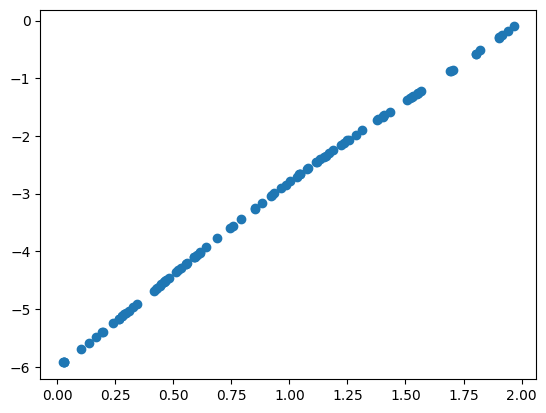

In [9]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

x=np.random.uniform(low=0.0, high=2.0, size=(100,1))

pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True)
pt_u = net(pt_x)
u=pt_u.data.cpu().numpy()
plt.scatter(x, u)
plt.show()

# We are a little bit before 0

1.0


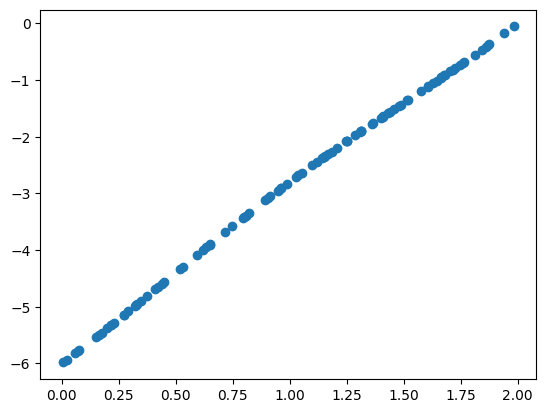

In [10]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

x=np.random.uniform(low=0.0, high=2.0, size=(100,1))
print(np.cos(np.pi*2))
u=3*(x - 2) - (np.cos(np.pi*x) - 1)*(1/(np.pi**2))
plt.scatter(x, u)
plt.show()

To impose *directly* the boundary conditions (usually gives better training results) you have to: 
* impose the condition directly on the output of the forward law multiplying the output by a function that does the job!
In our case: to make the solution zero at $x = 2$, a good function is $x - 2$. Thus ``(x - 2)*output``.
* Get rid of the Dirichlet cost: it is not needed anymore :)